In [ ]:
import pandas as pd
import re

# Load the dataset
df = pd.read_csv('/Users/matzchan/docs/Y1S2/SC15 DSAI/mini project/training.1600000.processed.noemoticon 2.csv', encoding='latin-1', header=None)
df.columns = ['polarity', 'id', 'date', 'query', 'user', 'text']

# Define a function to clean the text
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)     # Remove mentions
    text = re.sub(r'#', '', text)        # Remove hashtags
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)  # Remove punctuation
    text = text.lower()  # Convert to lowercase
    return text

# Apply cleaning to the text column
df['clean_text'] = df['text'].apply(clean_text)

# Save the cleaned data to a new file
clean_path = '/Users/matzchan/docs/Y1S2/SC15 DSAI/mini project/cleaned_tweets.csv'
df.to_csv(clean_path, index=False)
print(f'Cleaned data saved to {clean_path}')


CLEANING THE DATA

In [ ]:
TOKENISE AND REMOVING STOPWORDS


In [ ]:
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

# Download NLTK resources if not already installed
nltk.download('punkt')
nltk.download('stopwords')

# Load the cleaned data
df = pd.read_csv(clean_path)

# Define a function to tokenize and remove stopwords
def tokenize_and_remove_stopwords(text):
    tokens = word_tokenize(text)  # Tokenize
    tokens = [word for word in tokens if word not in stopwords.words('english')]  # Remove stopwords
    return ' '.join(tokens)

# Apply tokenization and stop word removal
df['tokenized_text'] = df['clean_text'].apply(tokenize_and_remove_stopwords)

# Save the tokenized data to a new file
tokenized_path = '/Users/matzchan/docs/Y1S2/SC15 DSAI/mini project/tokenized_tweets.csv'
df.to_csv(tokenized_path, index=False)
print(f'Tokenized data saved to {tokenized_path}')

LEMMMATIZING WORDS

In [ ]:
from nltk.stem import WordNetLemmatizer
import pandas as pd
import numpy as np

# Define a function for lemmatization with a check for non-string types
def lemmatize_text(text):
    if pd.isna(text) or not isinstance(text, str):
        return ''  # or return np.nan if you prefer to keep NaN values
    lemmatizer = WordNetLemmatizer()
    tokens = text.split()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(lemmatized_tokens)

# Assume df is your DataFrame loaded from the tokenized CSV
# Apply the lemmatization function
df['lemmatized_text'] = df['tokenized_text'].apply(lemmatize_text)

# Continue with your processing or saving steps


# Save the final processed data
final_output_path = '/Users/matzchan/docs/Y1S2/SC15 DSAI/mini project/processed_tweets.csv'
df.to_csv(final_output_path, index=False)
print(f'Final processed data saved to {final_output_path}')


EXPLORATORY DATA ANALYSIS

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk import FreqDist, word_tokenize
import nltk
from tqdm.auto import tqdm

# Ensure NLTK resources are downloaded
nltk.download('punkt')

# Load the processed data
df = pd.read_csv('/Users/matzchan/docs/Y1S2/SC15 DSAI/mini project/processed_tweets.csv')

# Sample 25% of the data randomly
df_sampled = df.sample(frac=0.1, random_state=42)

def tokenize_text(text):
    """Tokenizes text unless it's NaN, in which case it returns an empty list."""
    if pd.isna(text):
        return []
    return word_tokenize(str(text))

def apply_tokenization(column):
    """Applies the tokenization across a pandas Series with a progress bar for visibility."""
    return [tokenize_text(text) for text in tqdm(column, total=len(column), desc='Tokenizing Text')]

def calculate_word_frequencies(tokens_list):
    """Calculates and returns the frequency distribution of words in a list of tokens."""
    all_tokens = sum(tokens_list, [])
    freq_dist = FreqDist(all_tokens)
    return pd.DataFrame(freq_dist.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)

# Tokenization step with progress bar
df_sampled['tokens'] = apply_tokenization(df_sampled['tokenized_text'])

# Separate data by sentiment
negative_df = df_sampled[df_sampled['polarity'] == 0]
positive_df = df_sampled[df_sampled['polarity'] == 4]

# Calculate word frequencies with progress bars
negative_freq = calculate_word_frequencies(tqdm(negative_df['tokens'], desc='Processing Negative Tokens'))
positive_freq = calculate_word_frequencies(tqdm(positive_df['tokens'], desc='Processing Positive Tokens'))

# Prepare data for comparison
top_n = 20
top_negative_words = negative_freq.head(top_n)
top_positive_words = positive_freq.head(top_n)
compare_df = pd.merge(top_negative_words, top_positive_words, on='Word', how='outer', suffixes=('_neg', '_pos'))
compare_df.fillna(0, inplace=True)

def plot_data(data_frame):
    """Generates and displays plots for the given data."""
    # Bar Plot Comparison
    plt.figure(figsize=(14, 8))
    data_frame.set_index('Word').plot(kind='bar', figsize=(14, 6))
    plt.title('Top Word Frequencies by Sentiment')
    plt.ylabel('Frequency')
    plt.xlabel('Words')
    plt.show()

    # Violin Plot for frequency distribution
    plt.figure(figsize=(12, 8))
    sns.violinplot(data=data_frame[['Frequency_neg', 'Frequency_pos']])
    plt.title('Distribution of Word Frequencies in Negative and Positive Sentiments')
    plt.ylabel('Frequency')
    plt.xlabel('Sentiment')
    plt.xticks([0, 1], ['Negative', 'Positive'])
    plt.show()

    # Heatmap of word frequencies
    heatmap_data = data_frame[['Frequency_neg', 'Frequency_pos']].set_index(data_frame['Word'])
    plt.figure(figsize=(12, 10))
    sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="YlGnBu")
    plt.title('Heatmap of Word Frequencies')
    plt.show()

# Plotting the results with data
plot_data(compare_df)


VECTORISING USING WORD2VEC

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

df = pd.read_csv('/Users/matzchan/docs/Y1S2/SC15 DSAI/mini project/processed_tweets.csv')

# Initialize the CountVectorizer
vectorizer = CountVectorizer()

# Fit and transform the data
X_bow = vectorizer.fit_transform(df['lemmatized_text'].fillna(''))

# Example of feature names (vocabulary)
print(vectorizer.get_feature_names_out()[:10])  # Display first 10 features


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the data
X_tfidf = tfidf_vectorizer.fit_transform(df['lemmatized_text'].fillna(''))

# Example of feature names
print(tfidf_vectorizer.get_feature_names_out()[:10])  # Display first 10 features


In [33]:
from gensim.models import Word2Vec
import nltk

# Tokenize the sentences
df['tokens'] = df['lemmatized_text'].fillna('').apply(nltk.word_tokenize)

# Train a Word2Vec model 
model = Word2Vec(sentences=df['tokens'], vector_size=100, window=5, min_count=1, workers=4)

# Example of getting a vector for a word
word_vector = model.wv['example']  # Replace 'example' with a relevant word from your dataset
print(word_vector)


[-0.0374963   0.35365114 -0.20733492  0.12490724  0.11060168 -0.52926284
 -0.01267704  0.718971   -0.22653954 -0.26553535 -0.02834426 -0.5234946
 -0.15810917  0.20502315  0.14462076 -0.20753594  0.03194011 -0.48278597
  0.32928815 -0.53496736  0.3684711   0.11661899  0.1611437  -0.07528108
 -0.13008443  0.1123393  -0.06817615 -0.37413526 -0.14680852 -0.02311885
  0.5484645   0.12794554  0.06130024 -0.05523879 -0.03161808  0.21044289
  0.26324677 -0.5094701  -0.35537186 -0.65278095 -0.08233742 -0.00400269
 -0.03520166 -0.1864458   0.23173957 -0.3685568  -0.2692534  -0.12608714
  0.38196635  0.14202121 -0.19212578  0.11606234 -0.32023388 -0.02379689
  0.107067    0.12006015 -0.02724012  0.02789338 -0.10309459 -0.15598905
  0.24929479  0.1583937  -0.14580435  0.2572062  -0.48486683 -0.01825565
  0.01085354  0.03053951 -0.3917125   0.5081967  -0.29258594 -0.24253051
  0.05439566  0.2672059   0.15558267  0.06305068  0.1428546  -0.11899947
 -0.43466514  0.04146253 -0.1702961   0.2849282  -0.

FITTING AND TRAINING MODEL

In [1]:
import pandas as pd

# Load the data
df = pd.read_csv('/Users/matzchan/docs/Y1S2/SC15 DSAI/mini project/processed_tweets.csv')

# Sample 10% of the data
df_sampled = df.sample(frac=0.25, random_state=42)

# Save the sampled data to a new CSV file
df_sampled.to_csv('/Users/matzchan/docs/Y1S2/SC15 DSAI/mini project/sampled_tweets.csv', index=False)


In [2]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from tqdm.auto import tqdm  # Import tqdm for Jupyter Notebook compatibility

# Ensure NLTK resources are downloaded
nltk.download('punkt')

# Load your data
df = pd.read_csv('/Users/matzchan/docs/Y1S2/SC15 DSAI/mini project/sampled_tweets.csv')
df_sampled = df.sample(frac=0.1, random_state=42)


# Check if 'tokenized_text' exists and then tokenize it with a progress bar
if 'tokenized_text' in df.columns:
    tqdm.pandas(desc="Tokenizing Text")  # Set up tqdm with pandas
    df['tokens'] = df['tokenized_text'].progress_apply(lambda x: word_tokenize(str(x)) if pd.notna(x) else [])
else:
    print("Error: 'tokenized_text' column does not exist in the DataFrame.")


[nltk_data] Downloading package punkt to /Users/matzchan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Tokenizing Text:   0%|          | 0/400000 [00:00<?, ?it/s]

In [3]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from tqdm.auto import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
import gensim
from sklearn.model_selection import train_test_split
import numpy as np
import os

# Convert tokens back to strings for TF-IDF vectorization
df['text_str'] = df['tokens'].apply(lambda tokens: ' '.join(tokens))

# Initialize and fit the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=100)  # Adjust as necessary
X = tfidf_vectorizer.fit_transform(df['text_str']).toarray()

# Save the TF-IDF vectorizer to disk using pickle
with open('tfidf_vectorizer.pkl', 'wb') as file:
    pickle.dump(tfidf_vectorizer, file)
    print(f"TF-IDF vectorizer saved successfully to {os.path.abspath(file.name)}")

# Assuming 'tokens' is a list of tokenized text
documents = df['tokens'].tolist()

# Train Word2Vec model
word2vec_model = gensim.models.Word2Vec(documents, vector_size=100, window=5, min_count=2, workers=4)

# Function to average Word2Vec vectors for a document
def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,), dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary: 
            nwords += 1
            feature_vector = np.add(feature_vector, model.wv[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
    return feature_vector

# Prepare feature vectors for all documents
w2v_features = np.array([average_word_vectors(doc, word2vec_model, word2vec_model.wv.key_to_index, 100) for doc in documents])

# Prepare target variable
y = df['polarity']  # Assuming 'polarity' is your target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(w2v_features, y, test_size=0.25, random_state=42)


TF-IDF vectorizer saved successfully to /Users/matzchan/docs/Y1S2/SC15 DSAI/lab/LAB 8/tfidf_vectorizer.pkl


NAIVE BAYES MODEL

In [4]:
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
import pickle

# Initialize and train the Naive Bayes model (GaussianNB assuming continuous features)
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# Predict and evaluate the model
nb_predictions = nb_model.predict(X_test)
print("Naive Bayes Classification Report:\n", classification_report(y_test, nb_predictions))

# Save the trained Naive Bayes model using pickle
model_filename = 'naive_bayes_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(nb_model, file)
    print(f"Model saved successfully to {model_filename}")


Naive Bayes Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.78      0.71     49892
           4       0.73      0.59      0.65     50108

    accuracy                           0.69    100000
   macro avg       0.69      0.69      0.68    100000
weighted avg       0.69      0.69      0.68    100000

Model saved successfully to naive_bayes_model.pkl


In [5]:
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB

# Initialize and train the Naive Bayes model (GaussianNB assuming continuous features)
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# Predict and evaluate the model
nb_predictions = nb_model.predict(X_test)
print("Naive Bayes Classification Report:\n", classification_report(y_test, nb_predictions))


Naive Bayes Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.77      0.71     49892
           4       0.72      0.60      0.66     50108

    accuracy                           0.68    100000
   macro avg       0.69      0.68      0.68    100000
weighted avg       0.69      0.68      0.68    100000



LOGISTIC REGRESSION MODEL

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Initialize and train the Logistic Regression model
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

# Predict and evaluate the model
lr_predictions = lr_model.predict(X_test)
print("Logistic Regression Classification Report:\n", classification_report(y_test, lr_predictions))


Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.73      0.57        11
           1       0.62      0.36      0.45        14

    accuracy                           0.52        25
   macro avg       0.55      0.54      0.51        25
weighted avg       0.56      0.52      0.51        25



SVM MODEL

In [27]:
import time
from tqdm import tqdm
import threading
from sklearn.svm import SVC  # Ensure this import is present
from sklearn.metrics import classification_report
import numpy as np  # Assuming your X_train, etc., are numpy arrays or similar

# Assuming data setup for demonstration
# X_train, X_test, y_train, y_test = train_test_split(...)

# Function to simulate training progress
def simulate_training_progress(duration):
    pbar = tqdm(total=100, desc='Training SVM', unit='%', leave=True)
    for i in range(100):
        time.sleep(duration / 100)  # Sleep to simulate work
        pbar.update(1)
    pbar.close()

# Define the SVM training as a thread
class TrainSVM(threading.Thread):
    def __init__(self, X_train, y_train, X_test):
        threading.Thread.__init__(self)
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test

    def run(self):
        svm_model = SVC(kernel='linear')
        svm_model.fit(self.X_train, self.y_train)
        svm_predictions = svm_model.predict(self.X_test)
        print("SVM Classification Report:\n", classification_report(y_test, svm_predictions))

# Start the training and progress simulation
X_train, X_test, y_train, y_test = np.random.rand(100, 10), np.random.rand(25, 10), np.random.randint(0, 2, 100), np.random.randint(0, 2, 25)  # Example setup
training_thread = TrainSVM(X_train, y_train, X_test)
training_thread.start()

# Simulate training progress for an estimated duration (e.g., 30 seconds)
simulate_training_progress(30)

# Ensure the training thread has completed
training_thread.join()


Training SVM:   0%|          | 0/100 [00:00<?, ?%/s]

SVM Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.71      0.71        17
           1       0.38      0.38      0.38         8

    accuracy                           0.60        25
   macro avg       0.54      0.54      0.54        25
weighted avg       0.60      0.60      0.60        25



Training SVM: 100%|██████████| 100/100 [00:30<00:00,  3.27%/s]


In [8]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)  # Assuming X_train and y_train are properly prepared

# Predict and evaluate
rf_predictions = rf_model.predict(X_test)
print("Random Forest Classification Report:\n", classification_report(y_test, rf_predictions))


Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.64      0.64        11
           1       0.71      0.71      0.71        14

    accuracy                           0.68        25
   macro avg       0.68      0.68      0.68        25
weighted avg       0.68      0.68      0.68        25



GRU MODEL 

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Embedding, SpatialDropout1D
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming X_train and X_test are already tokenized and indexed
X_train_pad = pad_sequences(X_train, maxlen=50)
X_test_pad = pad_sequences(X_test, maxlen=50)

gru_model = Sequential()
gru_model.add(Embedding(input_dim=1000, output_dim=100, input_length=50))
gru_model.add(SpatialDropout1D(0.2))
gru_model.add(GRU(100, dropout=0.2, recurrent_dropout=0.2))
gru_model.add(Dense(1, activation='sigmoid'))

gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
gru_model.fit(X_train_pad, y_train, epochs=100, batch_size=128, validation_split=0.3)

# Evaluate the model
gru_predictions = gru_model.predict(X_test_pad)
gru_predictions = (gru_predictions > 0.5).astype(int)
print("GRU Classification Report:\n", classification_report(y_test, gru_predictions))


Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5000 - loss: 0.6922 - val_accuracy: 0.4000 - val_loss: 0.6943
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.5571 - loss: 0.6919 - val_accuracy: 0.4000 - val_loss: 0.6977
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5143 - loss: 0.6916 - val_accuracy: 0.4000 - val_loss: 0.7007
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.5143 - loss: 0.6947 - val_accuracy: 0.4000 - val_loss: 0.7023
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.5143 - loss: 0.6911 - val_accuracy: 0.4000 - val_loss: 0.7029
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.5143 - loss: 0.6891 - val_accuracy: 0.4000 - val_loss: 0.7028
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.5143 - loss: 0.6940 - val_accuracy: 0.4000 - val_loss: 0.7019
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.5286 - loss: 0.6950 - val_accuracy: 0.4000 - val_loss: 0.7010
Epoch 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

DECISION TREE, RANDOM FOREST AND GRID SEARCH MODELS

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
dt_predictions = dt_model.predict(X_test)
print("Decision Tree Classification Report:\n", classification_report(y_test, dt_predictions))

# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
print("Random Forest Classification Report:\n", classification_report(y_test, rf_predictions))

# Random Forest with Grid Search
param_grid = {
    'n_estimators': [100, 200],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [None, 10, 20],
    'criterion': ['gini', 'entropy']
}
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, cv=5, verbose=1)
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
print("Grid Search Best Score:", grid_search.best_score_)
grid_rf_predictions = grid_search.best_estimator_.predict(X_test)
print("Random Forest Grid Search Classification Report:\n", classification_report(y_test, grid_rf_predictions))


Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.73      0.70        11
           1       0.77      0.71      0.74        14

    accuracy                           0.72        25
   macro avg       0.72      0.72      0.72        25
weighted avg       0.72      0.72      0.72        25

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.64      0.64        11
           1       0.71      0.71      0.71        14

    accuracy                           0.68        25
   macro avg       0.68      0.68      0.68        25
weighted avg       0.68      0.68      0.68        25

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 100}
Grid Search Best Score: 0.52
Random Forest Grid Search Classification Report:
               precision   

Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


2/2 - 1s - 495ms/step - accuracy: 0.5444 - loss: 0.6924 - val_accuracy: 0.2000 - val_loss: 0.7043
Epoch 2/100
2/2 - 0s - 37ms/step - accuracy: 0.4222 - loss: 0.6999 - val_accuracy: 0.2000 - val_loss: 0.7143
Epoch 3/100
2/2 - 0s - 37ms/step - accuracy: 0.5333 - loss: 0.6922 - val_accuracy: 0.2000 - val_loss: 0.7228
Epoch 4/100
2/2 - 0s - 36ms/step - accuracy: 0.5111 - loss: 0.6918 - val_accuracy: 0.2000 - val_loss: 0.7287
Epoch 5/100
2/2 - 0s - 37ms/step - accuracy: 0.5222 - loss: 0.6896 - val_accuracy: 0.2000 - val_loss: 0.7340
Epoch 6/100
2/2 - 0s - 37ms/step - accuracy: 0.5111 - loss: 0.6867 - val_accuracy: 0.2000 - val_loss: 0.7397
Epoch 7/100
2/2 - 0s - 36ms/step - accuracy: 0.5111 - loss: 0.6906 - val_accuracy: 0.2000 - val_loss: 0.7435
Epoch 8/100
2/2 - 0s - 37ms/step - accuracy: 0.5000 - loss: 0.6907 - val_accuracy: 0.2000 - val_loss: 0.7405
Epoch 9/100
2/2 - 0s - 54ms/step - accuracy: 0.5000 - loss: 0.6911 - val_accuracy: 0.2000 - val_loss: 0.7425
Epoch 10/100
2/2 - 0s - 37ms/s

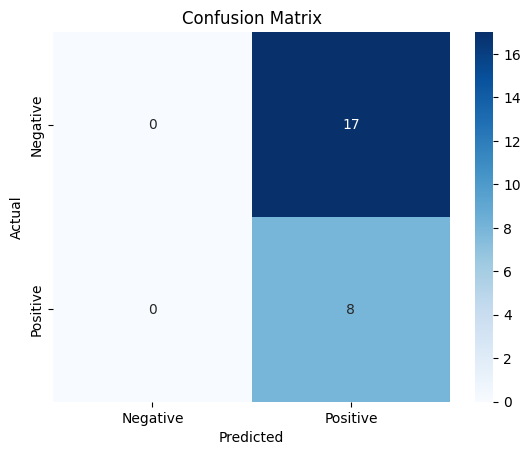

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, SpatialDropout1D, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Pad sequences for LSTM model
X_train_pad = pad_sequences(X_train, maxlen=50)  # Assuming max length is 50
X_test_pad = pad_sequences(X_test, maxlen=50)

# Compute class weights to handle class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

# Define the LSTM model with increased dropout to reduce overfitting
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=1000, output_dim=100, input_length=50))  # Adjust input_dim to your vocabulary size + 1
lstm_model.add(SpatialDropout1D(0.3))  # Increased dropout
lstm_model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))  # Increased dropout rates
lstm_model.add(Dropout(0.3))  # Additional dropout layer after LSTM
lstm_model.add(Dense(1, activation='sigmoid'))

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model with class weights
lstm_model.fit(X_train_pad, y_train, epochs=100, batch_size=64, validation_split=0.1, class_weight=class_weight_dict, verbose=2)

# Evaluate the model
lstm_predictions = lstm_model.predict(X_test_pad)
lstm_predictions = (lstm_predictions > 0.5).astype(int)

# Print classification report with zero_division parameter to handle undefined metrics gracefully
print("LSTM Classification Report:\n", classification_report(y_test, lstm_predictions, zero_division=0))

# Plot confusion matrix to further diagnose the model's performance
conf_matrix = confusion_matrix(y_test, lstm_predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB  # Import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score  # Import classification metrics
import pickle

# Load


# Load your cleaned and tokenized data
df = pd.read_csv('/Users/matzchan/docs/Y1S2/SC15 DSAI/mini project/tokenized_tweets.csv')

# Ensure all text data is string type and handle missing values
df['text_str'] = df['tokenized_text'].fillna('').apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

# Initialize and fit the TF-IDF vectorizer with bi-grams and tri-grams
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=1000)  # Adjust ngram_range and max_features as necessary

# Handling potential np.nan values by replacing them with empty strings
df['text_str'] = df['text_str'].fillna('')

X = tfidf_vectorizer.fit_transform(df['text_str'])

# Split the data into training and testing sets
y = df['polarity']  # Ensure the polarity column exists and is appropriate
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Save the TF-IDF vectorizer to disk using pickle for later use in model training
with open('tfidf_vectorizer.pkl', 'wb') as file:
    pickle.dump(tfidf_vectorizer, file)

print("TF-IDF features are ready for model training.")


In [ ]:
# Train a Naive Bayes model
naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(X_train, y_train)

# Predict on the test data
nb_predictions = naive_bayes_classifier.predict(X_test)

# Evaluate the model
print("Naive Bayes Classifier Metrics:")
print(classification_report(y_test, nb_predictions))
print("Accuracy:", accuracy_score(y_test, nb_predictions))


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression  # Import Logistic Regression
from sklearn.metrics import classification_report, accuracy_score
import pickle

# Train a Logistic Regression model
logistic_regression_classifier = LogisticRegression(max_iter=1000)  # Adjust max_iter if needed
logistic_regression_classifier.fit(X_train, y_train)

# Predict on the test data
lr_predictions = logistic_regression_classifier.predict(X_test)

# Evaluate the model
print("Logistic Regression Classifier Metrics:")
print(classification_report(y_test, lr_predictions))
print("Accuracy:", accuracy_score(y_test, lr_predictions))


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Initialize the Decision Tree Classifier
decision_tree_classifier = DecisionTreeClassifier(random_state=42)

# Train the model
decision_tree_classifier.fit(X_train, y_train)

# Predict on the test data
dt_predictions = decision_tree_classifier.predict(X_test)

# Evaluate the model
print("Decision Tree Classifier Metrics:")
print(classification_report(y_test, dt_predictions))
print("Accuracy:", accuracy_score(y_test, dt_predictions))


In [ ]:
# Initialize the Random Forest Classifier
random_forest_classifier = RandomForestClassifier(random_state=42)

# Train the model
random_forest_classifier.fit(X_train, y_train)

# Predict on the test data
rf_predictions = random_forest_classifier.predict(X_test)

# Evaluate the model
print("Random Forest Classifier Metrics:")
print(classification_report(y_test, rf_predictions))
print("Accuracy:", accuracy_score(y_test, rf_predictions))


In [ ]:
# Initialize the Random Forest Classifier
random_forest_classifier = RandomForestClassifier(random_state=42)

# Train the model
random_forest_classifier.fit(X_train, y_train)

# Predict on the test data
rf_predictions = random_forest_classifier.predict(X_test)

# Evaluate the model
print("Random Forest Classifier Metrics:")
print(classification_report(y_test, rf_predictions))
print("Accuracy:", accuracy_score(y_test, rf_predictions))


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense
from sklearn.model_selection import train_test_split

texts = df['text_str'].fillna('') 

# Tokenize text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Padding sequences to ensure uniform input size
max_sequence_length = max(len(x) for x in sequences)  
X = pad_sequences(sequences, maxlen=max_sequence_length)

# Labels
y = df['polarity'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense


model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100),
    LSTM(64),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Ensure data dimensions and types are correct
print("Shape of train data:", X_train.shape)
print("Shape of label data:", y_train.shape)

# Adjust batch size and number of epochs
batch_size = 8192  # Increase batch size for fewer steps per epoch
epochs = 1

model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"LSTM Model Accuracy: {accuracy}")


In [ ]:
# Define the GRU model
gru_model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_sequence_length),
    GRU(64),
    Dense(1, activation='sigmoid')
])

# Compile the model
gru_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
gru_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
gru_loss, gru_accuracy = gru_model.evaluate(X_test, y_test)
print(f"GRU Model Accuracy: {gru_accuracy}")


In [ ]:
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle

def load_model_and_vectorizer():
    """ Load the pre-trained Naive Bayes model and the TF-IDF vectorizer. """
    try:
        with open('naive_bayes_model.pkl', 'rb') as file:
            model = pickle.load(file)
        with open('tfidf_vectorizer.pkl', 'rb') as file:
            vectorizer = pickle.load(file)
        print("Model and vectorizer loaded successfully.")
        return model, vectorizer
    except FileNotFoundError:
        print("Model or vectorizer file not found. Please check the file path.")
        exit()
    except Exception as e:
        print(f"An error occurred: {e}")
        exit()

def get_tweet_sentiment(tweet, model, vectorizer):
    """ Predict the sentiment of a tweet using a pre-trained model and vectorizer. """
    if not tweet.strip():  # Check if the tweet is not just empty spaces
        return "No content to analyze"
    try:
        # Preprocess the tweet with the vectorizer
        tweet_vector = vectorizer.transform([tweet])
        tweet_vector_dense = tweet_vector.toarray()  # Convert to dense numpy array

        # Predict using the model
        prediction = model.predict(tweet_vector_dense)
        sentiment = 'positive' if prediction[0] == 1 else 'negative'
        return sentiment
    except Exception as e:
        print(f"An error occurred while processing the tweet: {e}")
        return "Error in prediction"


def main():
    """ Main function to load model and prompt user input for sentiment analysis. """
    model, vectorizer = load_model_and_vectorizer()
    
    while True:
        tweet = input("Enter a tweet, or type 'exit' to quit: ")
        if tweet.lower() == 'exit':
            print("Exiting program.")
            break
        sentiment = get_tweet_sentiment(tweet, model, vectorizer)
        print(f"The sentiment of the tweet: '{tweet}' is {sentiment}")

if __name__ == "__main__":
    main()


In [ ]:
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle

def load_model_and_vectorizer():
    """ Load the pre-trained Naive Bayes model and the TF-IDF vectorizer. """
    try:
        with open('naive_bayes_model.pkl', 'rb') as file:
            model = pickle.load(file)
        with open('tfidf_vectorizer.pkl', 'rb') as file:
            vectorizer = pickle.load(file)
        print("Model and vectorizer loaded successfully.")
        return model, vectorizer
    except FileNotFoundError:
        print("Model or vectorizer file not found. Please check the file path.")
        exit()
    except Exception as e:
        print(f"An error occurred: {e}")
        exit()


def get_tweet_sentiment(tweet, model, vectorizer):
    """ Predict the sentiment of a tweet using a pre-trained model and vectorizer. """
    if not tweet.strip():  # Check if the tweet is not just empty spaces
        return "No content to analyze"
    try:
        # Preprocess the tweet with the vectorizer
        tweet_vector = vectorizer.transform([tweet])
        tweet_vector_dense = tweet_vector.toarray()  # Convert to dense numpy array

        # Predict using the model
        prediction = model.predict(tweet_vector_dense)
        sentiment = 'positive' if prediction[0] == 1 else 'negative'
        return sentiment
    except Exception as e:
        print(f"An error occurred while processing the tweet: {e}")
        return "Error in prediction"


def main():
    """ Main function to load model and prompt user input for sentiment analysis. """
    model, vectorizer = load_model_and_vectorizer()
    
    while True:
        tweet = input("Enter a tweet, or type 'exit' to quit: ")
        if tweet.lower() == 'exit':
            print("Exiting program.")
            break
        sentiment = get_tweet_sentiment(tweet, model, vectorizer)
        print(f"The sentiment of the tweet: '{tweet}' is {sentiment}")

if __name__ == "__main__":
    main()


In [5]:
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
import pickle

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def load_model_and_vectorizer():
    """ Load the pre-trained Naive Bayes model and the TF-IDF vectorizer. """
    try:
        with open('naive_bayes_model.pkl', 'rb') as file:
            model = pickle.load(file)
        with open('tfidf_vectorizer.pkl', 'rb') as file:
            vectorizer = pickle.load(file)
        print("Model and vectorizer loaded successfully.")
        return model, vectorizer
    except FileNotFoundError:
        print("Model or vectorizer file not found. Please check the file path.")
        exit()
    except Exception as e:
        print(f"An error occurred: {e}")
        exit()






def main():
    """ Main function to load model and prompt user input for sentiment analysis. """
    model, vectorizer = load_model_and_vectorizer()
    
    while True:
        tweet = input("Enter a tweet, or type 'exit' to quit: ")
        if tweet.lower() == 'exit':
            print("Exiting program.")
            break
        sentiment = get_tweet_sentiment(tweet, model, vectorizer)
        print(f"The sentiment of the tweet: '{tweet}' is {sentiment}")

if __name__ == "__main__":
    main()


The sentiment of the tweet: 'HELLO' is negative
The sentiment of the tweet: 'i love you' is negative
